In [36]:
# requires older version of sklearn! 19.0 or older! (conda install scikit-learn==0.19)

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
from scipy.cluster.vq import vq, kmeans, whiten

# get election result code from g6
import sys
import os
sys.path.append(os.getcwd())
#from g6_run_code import *
#from shifter import *



#to make my plotting style
plt.rcParams["axes.facecolor"] = (1,1,.99) 
plt.rcParams["font.size"] = 15 
plt.rcParams["figure.figsize"] = (12,6) 
plt.rcParams["ytick.labelsize"] = 13 
plt.rcParams["xtick.labelsize"] = 13 
plt.rcParams["lines.linewidth"] = 2 
plt.rcParams["axes.titlesize"] = 17 

### Globals

In [18]:
NUM_PARTY_REPS = 3

### Kelley's Black Box / Get centroid update shifts

In [19]:
def polygon_population_calculator(centroid_to_polygon, population_map):
    from shapely.geometry import Polygon
    from shapely.geometry import Point
    import numpy as np
    '''
    Input:  
            1. dictionary that maps each centroid to its respective polygon
               dict[(cent_x, cent_y)] = [(vert1_x, vert1_y), (vert2_x, vert2_y)....]
            2. list of vertice tuples. Each tuple contains the location of a person.
            
        
    Output: 
            1.  dictionary that maps each centroid to its population count and its density
                dict[(cent_x, cent_y)] = [population_count, density]
            2.  dictionary that maps each centroid to its population info
                dict[(cent_x, cent_y)] = np.array([px,py,voterinfo....],[px,py,voterinfo....])
    
    
    '''

    centroid_to_pop_density = dict()
    centroid_to_people_info = dict()
    
    for centroid in centroid_to_polygon:
        
        centroid_to_people_info[centroid] = list()
        
        pop_amount, pop_density = 0,0
        # Create a Polygon object for this centroid
        poly_verts = centroid_to_polygon[centroid]
        current_polygon = Polygon(poly_verts)
        
        # Find the population amount inside
        for person in population_map:
            # Create a Point object for that person's coordinates
            p_point = Point((person[0], person[1]))
            # Incrememnt count if person is inside
            # Add person info if person is inside
            if current_polygon.contains(p_point):
                pop_amount += 1
                centroid_to_people_info[centroid].append(person)
        
        # Determine polygon's area for density calculation
        pop_density = (pop_amount / current_polygon.area)
        
        centroid_to_pop_density[centroid] = [pop_amount, pop_density]
        
        # Convert it to np Array 
        centroid_to_people_info[centroid] = np.array(centroid_to_people_info[centroid])
        
        
    return centroid_to_pop_density, centroid_to_people_info
                


def find_overpopulated_district_centroids(centroid_to_pop_density):
    import numpy as np
    
    """
    Input:
            1. centroid_to_pop_density: dict[(c_x,c_y)] = [pop_amount, pop_density]
            
    Ouput:
            1. high_pop_centroids: list[(c_x, c_y), (c1_x, c1_y)....]
    
    """
    
    # First: calculate the MEAN and the [Mean-10%, Mean+10%] thresholds
    districts_pop = list()
    
    for cent in centroid_to_pop_density:
        districts_pop.append(centroid_to_pop_density[cent][0])
    
    mean = np.mean(districts_pop)
    
    bottom_threshold, top_threshold = mean*.9, mean*1.1
    
#     print("Mean Population: ", mean)
#     print("Low Population Threshold: ", bottom_threshold)
#     print("High Population Threshold: ", top_threshold)
    
    # find which centroids have too high of a population
    too_high_cents = list()
    for cent in centroid_to_pop_density:
        if centroid_to_pop_density[cent][0] > top_threshold:
            too_high_cents.append(cent)
    
    return too_high_cents

def find_neighboring_centroids(target_centroids, centroid_to_polygon):
    from shapely import geometry
    from shapely.geometry import Point
    from shapely.geometry import Polygon
    import heapq
    """
    Input: 
            1. target_centroids: a list of centroid tuples(c_x, c_y) that you want to find centroid neighbors for
            2. centroid_to_polygon: dict[(c_x, c_y)] = list[(vert1_x, vert1_y), (vert2_x, vert2_y)...]
            
    Output:
            1. cent_to_neighbor_map: dict of a centroid to a list of its neighboring centroids
            dict[(c_x, c_y)] = [(n1_x, n1_y), (n2_x, n2_y)...]
    
    """
######################################################################  
#### Helper Function #################################################
    def is_adjacent(cent1, cent2):
        if cent1 == cent2:
            return False
        
        poly1 = Polygon(centroid_to_polygon[cent1])
        poly2 = Polygon(centroid_to_polygon[cent2])
        
        if type(poly1.intersection(poly2)) is geometry.LineString:
            return True
        else:
            return False
#######################################################################
        
    
    high_centroid_to_neighbor_map = dict()
    
    for target in target_centroids:
        neighbor_cents = list()
        for poss_neighbor in centroid_to_polygon:
            if is_adjacent(target, poss_neighbor):
                neighbor_cents.append(poss_neighbor)
        high_centroid_to_neighbor_map[target] = neighbor_cents
    
    return high_centroid_to_neighbor_map

def get_shift_direction(high_centroid_to_neighbors, centroid_to_pop_density):
    """
    Purpose: Given a centroid, find the direction to the nearest neighbor that has the lowest density
    
    Input: 
            1. high_centroid_to_neighbors: a dict mapping a centroid to its neighboring centroids
            
            2. centroid_to_pop_density: a dict mapping a centroid to its (population count, population density)
            
    Output:
            1. centroid_to_shift_mapping: a dict mapping a high centroid to the direction it should be shifted in
                dict[(hc_x,hc_y)] = np.array[x,y]
    """
    import numpy as np
    
    def calc_direction(p1, p2):
        x = p2[0] - p1[0]
        y = p2[1] - p1[1]
        return np.array([x,y])
          
    centroid_to_shift_mapping = dict()
    # First, find the target's neighbors
    for too_high_cent in high_centroid_to_neighbors:
        least_dense_neighbor = None
        lowest_density = float("inf")
        for neighbor in high_centroid_to_neighbors[too_high_cent]:
            n_density = centroid_to_pop_density[neighbor][1]
            
            if n_density < lowest_density:
                least_dense_neighbor = neighbor
                lowest_density = n_density
                
        centroid_to_shift_mapping[too_high_cent] = calc_direction(too_high_cent, least_dense_neighbor)
    
    return centroid_to_shift_mapping


def kelley_box_get_shift_directions(centroid_to_polygon, population_map):
    """
    Overall function that calls many functions.
    
    
    Input:
            1. dict[tuple(c_x,c_y)] = [(v1_x, v1_y), (v2_x, v2_y)...]
            Maps a centroid's coordinates (tuple) to a list of coordinates marking its polygon's vertices
            
            2. np.array[[x,y,voterinfo...]]
            A list of tuples. Each tuple is a person's coordinates. 
            
    Output:
            1. dict[tuple(hc_x, hc_y)] = np.array[x,y]
            Maps a high centroid to the (least dense) direction it should go.
            Note: if this dict is empty, that means each district satisfies the population constraint!
    
    """
    import pprint
    # First, get the centroid to population count and population density dict
    centroid_to_pop_density, centroid_to_people_info = polygon_population_calculator(centroid_to_polygon, population_map)
#     print("centroid_to_pop_density:")
#     pprint.pprint(centroid_to_pop_density)
#     for c in centroid_to_people_info:
#         print(c, ": ", len(centroid_to_people_info[c]))
    
    # Second, get a list of centroids that are the core of districts with TOO HIGH population
    too_high_centroids = find_overpopulated_district_centroids(centroid_to_pop_density)
#     print("too_high_centroids:")
#     pprint.pprint(too_high_centroids)
    
    # If there are none, return an empty dict.
    if len(too_high_centroids) == 0:
        return dict()
    
    # Third, find each centroid's nearest neighboring centroids
    high_centroid_to_neighbor_map = find_neighboring_centroids(too_high_centroids, centroid_to_polygon)
#     print("High Centroids' Neighbors:")
#     pprint.pprint(high_centroid_to_neighbor_map)
    
    # Fourth, find each centroids "shift" direction (dict)
    centroid_to_shift_mapping = get_shift_direction(high_centroid_to_neighbor_map, centroid_to_pop_density)
#     print("Centroid_to_shift_mapping:")
#     pprint.pprint(centroid_to_shift_mapping)
    
    # Fifth, return the high_centroid_shift_direction dict.
    return centroid_to_shift_mapping, centroid_to_people_info

def visualize_all(cent_to_poly, population_map):
    
    # plot each person coordinate
    for person in population_map:
        plt.plot(person[0], person[1], color='black', marker='o', markersize=2)
        
    for c in cent_to_poly:
        # plot each centroid
        plt.plot(c[0],c[1],color='purple', marker='o', markersize=8)
        
        # plot each polygon
        cur_poly = Polygon(cent_to_poly[c])
        x,y = cur_poly.exterior.xy
        plt.plot(x,y)

def get_centroid_poly_dict(centroids, polys):
    polys_dict = {}
    for i in range(len(centroids)):
        polys_dict[(centroids[i][0], centroids[i][1])] = polys[i]
    return polys_dict

### Geometry and function for generating random districts

In [20]:
# functions to get points on sides given x
def y_bottom(x):
    return 0
def y_left(x):
    return x * np.sqrt(3)
def y_right(x):
    return np.sqrt(3) * (1000 - x)

# check bounds
def in_bounds(point):
    x, y = point[0], point[1]
    condition1 = y >= y_bottom(x)
    condition2 = y <= y_left(x)
    condition3 = y <= y_right(x)
    return condition1 and condition2 and condition3

def generate_random_centroids(num_districts):
    centroids = np.zeros((num_districts,2))
    for i in range(num_districts):
        while True:
            x = np.random.random() * 1000
            y = np.random.random() * 1000
            proposal = np.array([x,y])
            if in_bounds(proposal):
                centroids[i] = proposal
                break
                
    return centroids

### Map information extraction functions

In [21]:
num_population = 333333
num_parties = 2 # default
Population_coords = []
Preferences = []
num_population_test = 333

def extractMapInfo(textfile, test=False):
    with open(textfile) as f:
        first_line = f.readline().split(" ")
        # get num_population
        file_num_population = int(first_line[0])
        if test:
            file_num_population = num_population_test
        # get num_parties
        num_parties = int(first_line[1])
        
        for i in range(file_num_population):
            person = f.readline().rstrip('\n').split(" ")
            Population_coords.append([float(x)  for x in person[:2]])
            Preferences.append([float(pref) for pref in person[2:(2 + num_parties)]])
    
# path = os.getcwd() + "/utah_2_better_map"
path = "/Users/rcalinsky/Dropbox/Columbia/4444/pps-election/maps/g4/other_maps/texas_2_real_data_map.map" # 2 party

extractMapInfo(path)



### Extract Populations by preference to be used for more sophisticated k-means centroids

In [22]:
Pop_1_coords = []
Pop_2_coords = []
Pop_3_coords = []

def extractSubPopulationCoords():
    party_pref = 1 # default
    
    for i in range(len(Population_coords)):
        for j in range(num_parties):
            # if this preference is the highest
            if Preferences[i][j] == max(Preferences[i]):
                if j == 0:
                    Pop_1_coords.append(Population_coords[i])
                if j == 1:
                    Pop_2_coords.append(Population_coords[i])
                if j == 2:
                    Pop_3_coords.append(Population_coords[i])

extractSubPopulationCoords()             

### Voronoi functions

In [23]:
# Credit for teselating Voronoi in python
# https://gist.github.com/pv/8036995
# https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647

def voronoi_finite_polygons_2d(vor, radius=None):
    
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def get_max_sides(districts):
    max_sides = 0
    for poly in districts:
        if len(poly) > max_sides:
            max_sides = len(poly)
    return max_sides

def get_districts(points, visualize=False):
    # compute Voronoi tesselation
    vor = Voronoi(points)

    # plot
    regions, vertices = voronoi_finite_polygons_2d(vor)
#    threeland = Polygon([[0,0], [1000,0], [500, 500 * 1.73]])
    threeland = Polygon([[0,0], [1000,0], [500, 500 * np.sqrt(3)]])
    districts = []
    
    if visualize:
        fig, ax = plt.subplots(1,1, figsize=(12,6))

    # colorize
    for region in regions:
        polygon = vertices[region]
        # Clipping polygon
        poly = Polygon(polygon)
        poly = poly.intersection(threeland)
        polygon = [p for p in poly.exterior.coords]
        if visualize:
            ax.fill(*zip(*polygon), alpha=0.4)
        districts.append(polygon)

#     ax.plot(points[:, 0], points[:, 1], 'ko', ms=3)
    if visualize:
        ax.axis('equal')
        ax.set_title("Preview of {} Districts".format(len(districts)))
    
    return districts

### Build file with voters and districts

In [24]:
newFileName = "map" + str(num_parties) + "_reps" + str(NUM_PARTY_REPS) + "_results"
# print (newFileName) # test

# get file ready (don't have districts yet)
def buildNewFile(mapfile):
    read_file = open(mapfile, "r")
    write_file = open(newFileName, "w")
    
    for i in range(num_population +1):
        write_file.write(read_file.readline())
    read_file.close()
    write_file.close()

buildNewFile(path)
num_districts = 243 / NUM_PARTY_REPS
    
def append_districts(name, districts):
    f = open(name, "a+")
    f.write(str(len(districts)) + "\n")
    for poly in districts:
        f.write(str(len(poly)) + " ")
        for vertex in poly:
            x, y = vertex[0], vertex[1]
            f.write(str(x) + " " + str(y) + " ")
        f.write("\n")
    f.close()

### Population thinner

In [25]:
# population is numpy array of shape (num_pop, 2).  x is idx 0 and y 1.
def thinner(population, thinned_length):
    sample = np.random.choice(len(population), thinned_length)
    return population[sample]

### Essential Data Structure Summary

districts is simply a list of polygons.  Each polygon is a list of vertices, each of which is a (x,y) tuple.

voters is a numpy array with shape = (num_voters, 2 + num_parties).  In other words, each voter is an x, y coord followed by their prefs for each party.

k_means_centroids is a numpy array of centroids, shape = (num_centroids, 2)

These 3 objects basically define our complete situation.  Everything we need to move on with analysis rests with algorithmically generating a valid set of these objects.  Once we can get 1 set, I can get 10,000 sets and generate all the voting / gerrymandering data we need.

### District validity checker

In [26]:
def check_validity(centroids, districts, voters):
    centroid_to_polygon = get_centroid_poly_dict(centroids, districts)
    centroid_to_shift_mapping, centroid_to_people_info = kelley_box_get_shift_directions(centroid_to_polygon, voters)
    num_invalid_districts = len(centroid_to_shift_mapping)
    if num_invalid_districts == 0:
        return True
    return False

### Make file / Get preview

In [27]:
Population_coords = np.array(Population_coords)
Preferences = np.array(Preferences)

voters = np.hstack((Population_coords, Preferences))
thinned_voters = thinner(voters, 1000)
thinned_Population_coords = thinned_voters[: ,0:2]



In [28]:
# time-consuming, n-p hard function
#from equal_groups import EqualGroupsKMeans

# egk = EqualGroupsKMeans(n_clusters = 243//NUM_PARTY_REPS, max_iter = 40)
# egk.fit(thinned_Population_coords)
# centroids_equal_pop = egk.cluster_centers_
# len(thinned_Population_coords)

### Vanilla k-means functions satisfying pop restriction

In [29]:
# repurposed from https://github.com/ndanielsen/Same-Size-K-Means
from equal_groups import EqualGroupsKMeans

# break up pop in 9;
# compute k number of clusters for the people in each smaller triangle
# in proportion to the population there



def get_nine_pops( thinned_pop ): # len(thinned_pop) = 1000
    
    # first, define sub-districts using their centers

    # 9 centers with two coordinates (used to define each of the 9 sub-districts)
    Pops_Nine_Centers = np.zeros((9, 2))
    
    centroid_of_3_land = np.array([500, 500/np.sqrt(3)])

    inner_radius = 2/3 * 500/np.sqrt(3)
    # inner 6 districts surrounding centroid of 3-land
    for i in range(6):
        angle = 2*np.pi * i/6
        direction = np.array([np.sin(angle), np.cos(angle)])
        Pops_Nine_Centers[i] = centroid_of_3_land + inner_radius * direction
    
    outer_radius = inner_radius *2
    for i in range(3):
        angle = 2*np.pi * i/3
        direction = np.array([np.sin(angle), np.cos(angle)])
        Pops_Nine_Centers[i +6] = centroid_of_3_land + outer_radius * direction
    
    # second, find distances between each sub-district center and all the people
    Pop_Distances = np.zeros((len(thinned_pop), 9))
    for i, pops_nine_center_i in enumerate(Pops_Nine_Centers):
        # nice way to subtract xs and ys all at once!
        offsets_i = thinned_pop - pops_nine_center_i
        distances_i = np.sqrt((offsets_i**2).sum(axis = 1))
        # set everything for the ith column
        Pop_Distances[:,i] = distances_i
        
    # third, add person from thinned-pop to sub-district with "center" that it's closest to
    # argmin tells us which of the boxes led to that minimum; one-liner returns index (AKA sub-district number)!
    Pop_Indices = Pop_Distances.argmin(axis = 1)
    
    # fourth, for each district, consolidate belonging points
    Pops_Nine = [None] *9
    
    for i in range(9):
        # boolean corresponding to when i is the same and any one of the pop indices; one-liner!
        belongs_to_district_i = Pop_Indices == i
        # extract only the belonging population
        Pops_Nine[i] = thinned_pop[belongs_to_district_i]

    # plot to see what's going on
    import matplotlib.pyplot as plt
    plt.plot(Pops_Nine_Centers[:,0], Pops_Nine_Centers[:,1], "kx")
    plt.scatter(thinned_pop[:,0], thinned_pop[:,1], c = Pop_Indices)
    plt.axis("equal")
    plt.show()
    
    return Pops_Nine




def get_k( Pops_Nine ):
    
    Ks_Nine = [None] *len(Pops_Nine)
    
    num_thinned_pop = len(thinned_voters)
    
    # pops_nine_i is index i of Pops_Nine
    for i, pops_nine_i in enumerate(Pops_Nine):
        fractional_population = len(pops_nine_i) /num_thinned_pop
        Ks_Nine[i] = int(num_districts *fractional_population) # the floor
        
    # set the very first k to what is needs to be to ensure correct sum of ks (& add all ks except for very first)
    Ks_Nine[0] = int(num_districts - sum(Ks_Nine[1:]))
    
    return Ks_Nine



def get_nine_pops_centroids( Pops_Nine, Ks_Nine ):
    Centroids_Nine_Consolidated = []

    for i, ks_nine_i in enumerate(Ks_Nine):
        if ks_nine_i == 0:  continue

        egk = EqualGroupsKMeans(n_clusters = ks_nine_i, max_iter = 40)
        egk.fit(Pops_Nine[i])
        centroids = egk.cluster_centers_
        # need to append them one after the other
        Centroids_Nine_Consolidated.append(centroids)

    # concatenate the merged points
    Centroids_Nine_Consolidated = np.concatenate(Centroids_Nine_Consolidated)
    return Centroids_Nine_Consolidated

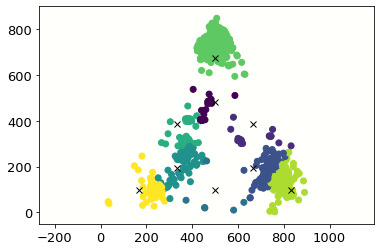

In [30]:
Pops_Nine = get_nine_pops(thinned_Population_coords)

In [31]:
Ks_Nine = get_k(Pops_Nine)
print(Ks_Nine)

# the following will take some time to load (can increase max_iter to get better results)
Centroids_Nine_Consolidated = get_nine_pops_centroids(Pops_Nine, Ks_Nine)

[5, 1, 14, 0, 8, 3, 26, 16, 8]


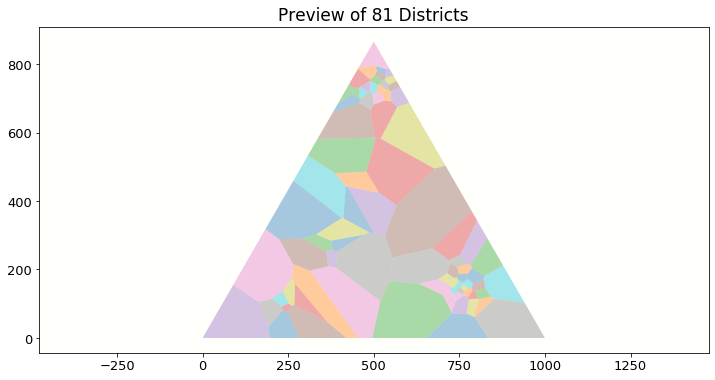

In [32]:
#k_means_centroids_81, distortion = kmeans(thinned_Population_coords, 81) 

districts = get_districts(Centroids_Nine_Consolidated, visualize=True) 

# print(Preferences.shape)
# print(Population_coords.shape)
# print(thinned_voters.shape)
# print(thinned_Population_coords.shape)

append_districts(newFileName, districts)

In [33]:

validity = check_validity(Centroids_Nine_Consolidated, districts, thinned_voters)
#print(validity)

### Attempt to iterative improvement.  Try fixing black box to do the opposite as discussed.

In [34]:
import copy
def update_centroids(in_centroids, centroid_to_shift_mapping, lr):
    centroids = copy.deepcopy(in_centroids)
    while True:
        i = np.random.randint(len(centroids))
        centroid_tup = (centroids[i][0], centroids[i][1])
        if centroid_tup in centroid_to_shift_mapping:
            shift = centroid_to_shift_mapping[centroid_tup]
            print("SHIFT: ", shift * lr, "LOCATION: ", centroids[i])
            centroids[i] += shift * lr
            break
    return centroids

In [35]:
from tqdm import tqdm
for i in range(100000):
    centroid_to_polygon = get_centroid_poly_dict(Centroids_Nine_Consolidated, districts)
    centroid_to_shift_mapping, centroid_to_people_info = kelley_box_get_shift_directions(centroid_to_polygon, thinned_voters)
    if i % 10 == 0:
        print("Remaining Bad Districts:  ", len(centroid_to_shift_mapping))
    if len(centroid_to_shift_mapping) == 0:
        print("Success!")
        break
    centroids_equal_pop = update_centroids(Centroids_Nine_Consolidated, centroid_to_shift_mapping, .5)
    districts = get_districts(centroids_equal_pop)

Remaining Bad Districts:   33
SHIFT:  [ 10.07740259 -10.31705742] LOCATION:  [814.80973995  99.34499991]
SHIFT:  [10.26940937 -1.58687606] LOCATION:  [752.99016448 137.92055578]
SHIFT:  [ 6.03487482 19.85821192] LOCATION:  [759.06203929 198.18199216]
SHIFT:  [32.4278979  50.01263365] LOCATION:  [391.74819871 406.72301052]
SHIFT:  [ -0.80031004 -12.00676334] LOCATION:  [533.85416682 737.89050562]
SHIFT:  [17.27142053 -1.36142367] LOCATION:  [374.58892125 239.31985696]
SHIFT:  [-27.44101124 -11.00126174] LOCATION:  [751.77271603 223.67371594]
SHIFT:  [ 28.33829477 -10.11042327] LOCATION:  [790.00114895 175.82237879]
SHIFT:  [-18.04064751  -9.10194405] LOCATION:  [725.24659128 123.97082655]
SHIFT:  [ 12.32842123 -38.44241987] LOCATION:  [566.10755235 716.63289846]
Remaining Bad Districts:   33
SHIFT:  [-1.7596627  19.05252784] LOCATION:  [492.13311415 775.13322135]
SHIFT:  [ 8.89716365 -5.82590978] LOCATION:  [243.43274992  89.4062288 ]
SHIFT:  [ 10.07740259 -10.31705742] LOCATION:  [814.

KeyboardInterrupt: 